In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, make_scorer

sns.set()

In [2]:
# --- 1. Load Data ---
cars = pd.read_csv("project_data/train.csv")

In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


In [4]:
cars.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
carID,75973.0,NaN,NaN,NaN,37986.0,21931.660338,0.0,18993.0,37986.0,56979.0,75972.0
Brand,74452,72,Ford,14808,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,74456,735,Focus,6353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,74482.0,NaN,NaN,NaN,2017.096611,2.208704,1970.0,2016.0,2017.0,2019.0,2024.121759
price,75973.0,NaN,NaN,NaN,16881.889553,9736.926322,450.0,10200.0,14699.0,20950.0,159999.0
transmission,74451,40,Manual,38050,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mileage,74510.0,NaN,NaN,NaN,23004.184088,22129.788366,-58540.574478,7423.25,17300.0,32427.5,323000.0
fuelType,74462,34,Petrol,37995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tax,68069.0,NaN,NaN,NaN,120.329078,65.521176,-91.12163,125.0,145.0,145.0,580.0
mpg,68047.0,NaN,NaN,NaN,55.152666,16.497837,-43.421768,46.3,54.3,62.8,470.8


In [5]:
cars.shape

(75973, 14)

In [6]:
print("--- Inspection of Categorical Features (Unique Values) ---")
for col in ['Brand', 'transmission', 'fuelType']:
    print(f"\n--- Column: {col} ---")
    
    # 2.1. Normalize Casing
    # Apply title case for consistent counting (e.g., 'petrol' and 'Petrol' become 'Petrol')
    normalized_series = cars[col].astype(str).str.title().str.strip()
    
    # 2.2. Get Value Counts
    # Use value_counts(dropna=False) to include NaN counts (represented as 'Nan' after astype(str))
    counts = normalized_series.value_counts(dropna=False)
    
    # 2.3. Output Results
    if len(counts) > 50:
        # For high-cardinality columns (like Brand), show the top 10 counts
        print(f"Total Unique Values: {len(counts) - (1 if 'Nan' in counts.index else 0)}")
        print(f"Top 10 Values and their Occurrences:")
        print(counts.nlargest(10).to_markdown(numalign="left", stralign="left"))
    else:
        # For low-cardinality columns (transmission, fuelType), show all counts
        print("All Unique Values and their Occurrences:")
        print(counts.to_markdown(numalign="left", stralign="left"))

--- Inspection of Categorical Features (Unique Values) ---

--- Column: Brand ---
All Unique Values and their Occurrences:
| Brand    | count   |
|:---------|:--------|
| Ford     | 15431   |
| Mercedes | 11209   |
| Vw       | 9973    |
| Opel     | 8979    |
| Bmw      | 7102    |
| Audi     | 7028    |
| Toyota   | 4455    |
| Skoda    | 4138    |
| Hyundai  | 3201    |
| Nan      | 1521    |
| Ord      | 320     |
| For      | 305     |
| Ercedes  | 236     |
| Mercede  | 222     |
| W        | 208     |
| V        | 204     |
| Ope      | 188     |
| Pel      | 181     |
| Mw       | 149     |
| Aud      | 147     |
| Udi      | 147     |
| Bm       | 141     |
| Oyota    | 93      |
| Koda     | 82      |
| Skod     | 81      |
| Toyot    | 74      |
| Yundai   | 68      |
| Hyunda   | 64      |
| Ercede   | 7       |
| Or       | 7       |
| Pe       | 4       |
| Yunda    | 3       |
| Ud       | 3       |
| Kod      | 2       |

--- Column: transmission ---
All Unique Values a

In [7]:
cars['transmission'] = cars['transmission'].astype(str).str.title()

# 1.2. Manually replace the identified typo 'Anual' with the correct 'Manual'
# The .replace() method will only change the specified value.
cars['transmission'] = cars['transmission'].replace([' Manual ', 'Manual ', ' Manual', 'Anual', 'Manua', 'Anua'], 'Manual')
cars['transmission'] = cars['transmission'].replace(['Semi-Aut', 'Emi-Auto', 'Emi-Aut'], 'Semi-Auto')
cars['transmission'] = cars['transmission'].replace(['Automati', 'Utomatic', 'Utomati', 'Utomatic'], 'Automatic')
cars['transmission'] = cars['transmission'].replace(['Unknow', 'Nknown', 'Nknow'], 'Unknown')

cars['Brand'] = cars['Brand'].astype(str).str.title()
cars['Brand'] = cars['Brand'].replace(['Ord', 'For', 'Or'], 'Ford')
cars['Brand'] = cars['Brand'].replace(['Ercedes', 'Mercede', 'Ercede'], 'Mercedes')
cars['Brand'] = cars['Brand'].replace(['Skod', 'Koda', 'Kod'], 'Skoda')
cars['Brand'] = cars['Brand'].replace(['Ope', 'Pel', 'Pe'], 'Opel')
cars['Brand'] = cars['Brand'].replace(['Aud', 'Udi', 'Ud'], 'Audi')
cars['Brand'] = cars['Brand'].replace(['Bm', 'Mw'], 'Bmw')
cars['Brand'] = cars['Brand'].replace(['Yundai', 'Hyunda', 'Yunda'], 'Hyundai')
cars['Brand'] = cars['Brand'].replace(['Oyota', 'Toyot', 'Ercede'], 'Toyota')
cars['Brand'] = cars['Brand'].replace(['V', 'W'], 'Vw')

cars['fuelType'] = cars['fuelType'].astype(str).str.title()
cars['fuelType'] = cars['fuelType'].replace(['Petro', 'Etrol', 'Etro'], 'Petrol')
cars['fuelType'] = cars['fuelType'].replace(['Iesel', 'Diese', 'Iese'], 'Diesel')
cars['fuelType'] = cars['fuelType'].replace(['Hybri', 'Ybrid', 'Ybri'], 'Hybrid')
cars['fuelType'] = cars['fuelType'].replace(['Othe', 'Ther'], 'Other')

In [8]:
# replace negative values
print(f'Milage have {(cars['mileage'] < 0).sum()} negative values')
cars['mileage'] = cars['mileage'].apply(lambda x: x if x>=0 else np.nan)

print(f'Miles per gallon have {(cars['mpg'] < 0).sum()} negative values')
cars['mpg'] = cars['mpg'].apply(lambda x: x if x>=0 else np.nan)

print(f'Tax have {(cars['tax'] < 0).sum()} negative values')
cars['tax'] = cars['tax'].apply(lambda x: x if x>=0 else np.nan)

print(f'engineSize have {(cars['engineSize'] < 0).sum()} negative values')
cars['engineSize'] = cars['engineSize'].apply(lambda x: x if x>=0 else np.nan)

print(f'previousOwners have {(cars['previousOwners'] < 0).sum()} negative values')
cars['previousOwners'] = cars['previousOwners'].apply(
    lambda x: int(x) if pd.notna(x) else np.nan
)
cars.loc[cars['previousOwners'] < 0, 'previousOwners'] = pd.NA


Milage have 369 negative values
Miles per gallon have 36 negative values
Tax have 378 negative values
engineSize have 84 negative values
previousOwners have 371 negative values


In [9]:
cars['fuelType'].isna().sum()

np.int64(0)

In [10]:
cars.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
carID,75973.0,NaN,NaN,NaN,37986.0,21931.660338,0.0,18993.0,37986.0,56979.0,75972.0
Brand,75973,10,Ford,16063,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,74456,735,Focus,6353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,74482.0,NaN,NaN,NaN,2017.096611,2.208704,1970.0,2016.0,2017.0,2019.0,2024.121759
price,75973.0,NaN,NaN,NaN,16881.889553,9736.926322,450.0,10200.0,14699.0,20950.0,159999.0
transmission,75973,6,Manual,41627,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mileage,74141.0,NaN,NaN,NaN,23352.797092,21620.630248,1.0,7556.0,17416.0,32510.0,323000.0
fuelType,75973,6,Petrol,41181,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tax,67691.0,NaN,NaN,NaN,121.259276,64.493191,0.0,125.0,145.0,145.0,580.0
mpg,68011.0,NaN,NaN,NaN,55.204844,16.345534,1.1,46.3,54.3,62.8,470.8


In [43]:
X = cars.drop(['carID', 'model', 'hasDamage'], axis = 1)
y = cars['price']

In [44]:
for feature in X.columns:
    print(f'There are {X[feature].isna().sum()} Nan values in {feature}')

There are 0 Nan values in Brand
There are 1491 Nan values in year
There are 0 Nan values in price
There are 0 Nan values in transmission
There are 1832 Nan values in mileage
There are 0 Nan values in fuelType
There are 8282 Nan values in tax
There are 7962 Nan values in mpg
There are 1600 Nan values in engineSize
There are 1524 Nan values in paintQuality%
There are 1921 Nan values in previousOwners


In [45]:
numerical_features = ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners']
categorical_features = ['Brand', 'transmission', 'fuelType']

In [46]:
X['year'].median()

2017.0

In [47]:
for col in numerical_features:
    median_val = X[col].median()
    print(f'Median of {col} is {median_val}')
    X[col] = X[col].fillna(median_val)

Median of year is 2017.0
Median of mileage is 17416.0
Median of tax is 145.0
Median of mpg is 54.3
Median of engineSize is 1.6
Median of paintQuality% is 65.0
Median of previousOwners is 2.0


In [60]:
X['fuelType'].unique()

array(['Petrol', 'Diesel', 'Hybrid', 'Other', 'Electric'], dtype=object)

In [49]:
for col in categorical_features:
    X[col] = X[col].replace('Nan', np.nan)
    mode_val = X[col].mode()[0]
    X[col] = X[col].fillna(mode_val)

In [50]:
X['previousOwners'] = X['previousOwners'].astype('int64')
X['year'] = X['year'].astype('int64')

In [51]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           75973 non-null  object 
 1   year            75973 non-null  int64  
 2   price           75973 non-null  int64  
 3   transmission    75973 non-null  object 
 4   mileage         75973 non-null  float64
 5   fuelType        75973 non-null  object 
 6   tax             75973 non-null  float64
 7   mpg             75973 non-null  float64
 8   engineSize      75973 non-null  float64
 9   paintQuality%   75973 non-null  float64
 10  previousOwners  75973 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 6.4+ MB


In [52]:
X['year'].unique()

array([2016, 2019, 2018, 2014, 2017, 2020, 2013, 2015, 2023, 2011, 2012,
       2003, 2009, 2007, 2005, 2004, 2010, 2008, 2024, 2006, 2001, 2000,
       2002, 2022, 1996, 1998, 1970, 1999, 1997])

In [53]:
X_encoded = pd.get_dummies(
    X, 
    columns=categorical_features, 
    drop_first=False,
    dtype=int
)

In [54]:
X_numeric = X.drop(['transmission', 'Brand', 'fuelType'], axis=1)

In [55]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

In [58]:
spearman_cor = X_numeric.corr(method='spearman')

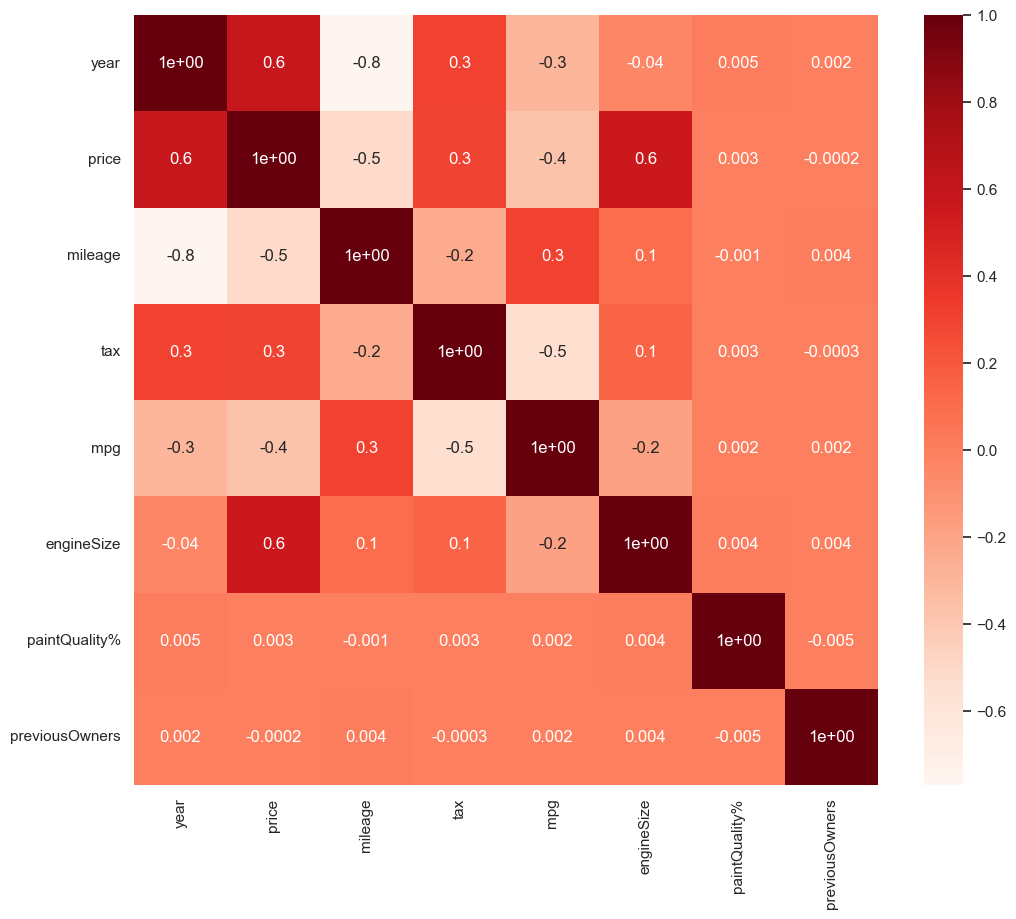

In [59]:
cor_heatmap(spearman_cor)